https://huggingface.co/learn/deep-rl-course/en/unit4/introduction

# Import

In [2]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import Categorical
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time


# Global params

In [3]:
DEVICE = "cpu"
ROOT = os.getcwd()
ENV_NAME = 'LunarLander-v2'
OUTPUT = os.path.join(ROOT, 'output', ENV_NAME)

if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)


# Test env

  0%|          | 0/10 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 10/10 [00:00<00:00, 144.66it/s]


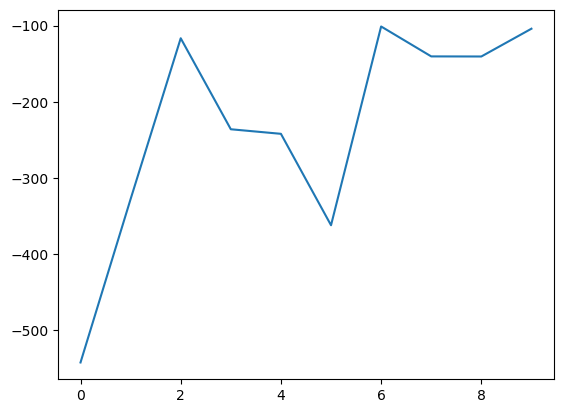

In [4]:
env = gym.make(ENV_NAME)
obs, info = env.reset()

rewards = []
for ep in tqdm(range(10)):
    obs, info = env.reset()
    total_reward = 0

    for t in count():
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if terminated or truncated: 
            break
    
    rewards.append(total_reward)

sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.show()
env.close()

# Actor and Critic Net

In [27]:
class ActorNet(nn.Module):

    def __init__(self, state_size, action_size, device, hidden_size = 64):
        super().__init__()
        self.device = device
        self.fc1 = nn.Linear(state_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, action_size) 

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return F.softmax(self.fc3(X), dim = -1)
    
    def act(self, state):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        probs = self(state).cpu()
        m = Categorical(probs)
        #we want to sample an action from the probability distribution over actions.
        action = m.sample()
        return action.item(), m.log_prob(action)


In [28]:
class CriticNet(nn.Module):
    def __init__(self, state_size, device, hidden_size = 64):
        super().__init__()
        self.fc1 = nn.Linear(state_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size) 
        self.fc3 = nn.Linear(hidden_size, 1) 
        self.device = device
        self.to(device)

    def forward(self, state):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        return self.fc3(state)

In [14]:
# Test model
env = gym.make(ENV_NAME)
obs, info = env.reset()
state_size = len(obs)
action_size = env.action_space.n

print('state size = ', state_size)
print('action size = ', action_size)

actor = ActorNet(state_size, action_size, device = DEVICE)
critic = CriticNet(state_size, device = DEVICE)

sample_state = np.random.rand(state_size)
print(sample_state.shape)

action, action_prob = actor.act(sample_state)
print('action = ', action)
print('action prob = ', action_prob)

value = critic(sample_state)
print('value = ', value)

env.close()

state size =  8
action size =  4
(8,)
action =  0
action prob =  tensor([-1.4058], grad_fn=<SqueezeBackward1>)
value =  tensor([[-0.0375]], grad_fn=<AddmmBackward0>)


In [15]:
print(np.finfo(np.float32).eps.item())

1.1920928955078125e-07


# A2C algo

In [23]:
def a2c(env, actor, critic, optimA, optimC, training_epochs, max_t, gamma, label = 'baseline', plot_update_freq = 50):

    SAVE_PATH = os.path.join(OUTPUT, label)
    FIG_SAVE_PATH = os.path.join(SAVE_PATH, 'plot.png')
    if os.path.exists(SAVE_PATH) == False:
        os.makedirs(SAVE_PATH)
    
    scores_deque = deque(maxlen = 100)
    history = defaultdict(list)
    loop = tqdm(range(training_epochs))
    best_score = -float('inf')

    for e in loop:

        saved_log_probs = []
        rewards = []
        state, info = env.reset()
        dones = []
        state_values = []


        for t in range(max_t):
            done = False
            action, log_prob = actor.act(state)
            saved_log_probs.append(log_prob)

            state_value = critic(state)
            state_values.append(state_value)

            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)

            if terminated or truncated:
                done = True
                break
                
            dones.append(done)
        
        #update actor
        scores_deque.append(sum(rewards))
        avg_reward = np.mean(scores_deque)

        history['reward'].append(avg_reward)

        returns = deque(maxlen = max_t)

        #compute cummulative reward
        num_steps = len(rewards)

        for t in reversed(range(num_steps)):
            G_t = returns[0] if len(returns) > 0 else 0
            returns.appendleft(gamma * G_t + rewards[t])

        #standardization of returns to make training more stable
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns).float()
        returns = (returns - returns.mean())/(returns.std() + eps)

        # returns = torch.cat(returns)
        state_values = torch.cat(state_values)
        saved_log_probs = torch.cat(saved_log_probs)

        #advantage function
        advantage = returns - state_values

        actor_loss = []
        #advantage.detach() because we don't want to backward the advantage 
        #that's for critic loss backward
        actor_loss = (-saved_log_probs * advantage.detach()).sum()

        critic_loss = F.mse_loss(returns, state_values)

        # print('actor loss = ', actor_loss.item())
        # print('critic loss = ', critic_loss.item())

        optimA.zero_grad()
        optimC.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        optimA.step()
        optimC.step()

        #statistics and saving checkpoint
        loop.set_description(f'avg reward = {avg_reward:.2f}')

        if best_score <= avg_reward:
            best_score = avg_reward
            torch.save(actor, os.path.join(SAVE_PATH, 'actor.checkpoint.torch'))
            torch.save(critic, os.path.join(SAVE_PATH, 'critic.checkpoint.torch'))
        
        if e % plot_update_freq == 0:
            plot(history, save_path=FIG_SAVE_PATH)
        
    plot(history, show=True, save_path=FIG_SAVE_PATH)
    torch.save(actor, os.path.join(SAVE_PATH, 'actor.final.torch'))
    torch.save(critic, os.path.join(SAVE_PATH, 'critic.final.torch'))

    return history

def plot(history, show = False, save_path = None):
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))))

    if save_path != None:
        plt.savefig(save_path)
    if show:
        plt.show()
        
    plt.clf()
    plt.close()

# Train

state size =  8
action size =  4


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
avg reward = 202.00: 100%|██████████| 10000/10000 [31:18<00:00,  5.32it/s]  


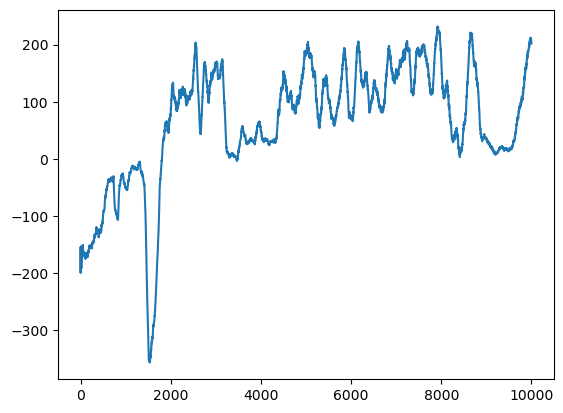

In [30]:
training_epochs = 10000
max_t = 1000
gamma = 1.0
lr = 1e-3
hidden_size = 128

device = DEVICE

env = gym.make(ENV_NAME)
obs, info = env.reset()
state_size = len(obs)
action_size = env.action_space.n
print('state size = ', state_size)
print('action size = ', action_size)

# model = PolicyNet(state_size, action_size, hidden_size = 16, device = 'cpu')
actor = ActorNet(state_size, action_size, hidden_size = hidden_size, device = device)
critic = CriticNet(state_size, hidden_size = hidden_size, device = device)
optimA = torch.optim.Adam(actor.parameters(), lr = lr)
optimC = torch.optim.Adam(critic.parameters(), lr = lr)

a2c(env, actor, critic, optimA, optimC, training_epochs=training_epochs, max_t = max_t, gamma = gamma)

env.close()



In [32]:
training_epochs = 10000
max_t = 1000
gamma = 1.0
lr = 1e-4
hidden_size = 256

device = DEVICE

env = gym.make(ENV_NAME)
obs, info = env.reset()
state_size = len(obs)
action_size = env.action_space.n
print('state size = ', state_size)
print('action size = ', action_size)

# model = PolicyNet(state_size, action_size, hidden_size = 16, device = 'cpu')
actor = ActorNet(state_size, action_size, hidden_size = hidden_size, device = device)
critic = CriticNet(state_size, hidden_size = hidden_size, device = device)
optimA = torch.optim.Adam(actor.parameters(), lr = lr)
optimC = torch.optim.Adam(critic.parameters(), lr = lr)

a2c(env, actor, critic, optimA, optimC, training_epochs=training_epochs, max_t = max_t, gamma = gamma)

env.close()



state size =  8
action size =  4


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
avg reward = -14.23:  50%|█████     | 5004/10000 [19:26<38:23,  2.17it/s]  

# Evaluate

  0%|          | 0/100 [00:00<?, ?it/s]/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
reward = 500.00: 100%|██████████| 100/100 [00:06<00:00, 15.15it/s]


<Axes: >

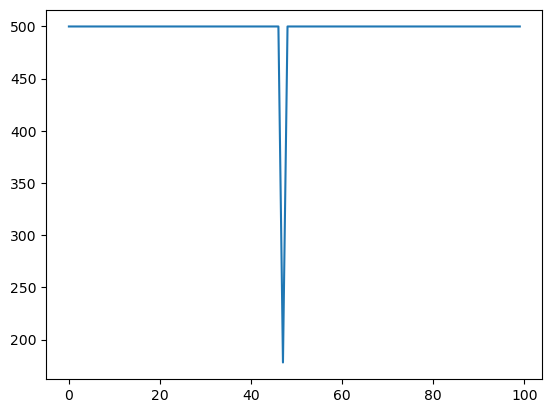

In [26]:
# nv = gym.make('CartPole-v1')
env = gym.make(ENV_NAME)
rewards = []

# net = torch.load('best_target_net.torch')
LOAD_PATH = os.path.join(OUTPUT, 'baseline', 'actor.final.torch')
eval_net = torch.load(LOAD_PATH)

loop = tqdm(range(100))
total_rewards = []

for epoch in loop:
    state, info = env.reset()
    total_reward = 0

    for t in range(max_t):

        action, log_prob = eval_net.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += 1
        if terminated or truncated:
            break
    
    total_rewards.append(total_reward)
    loop.set_description(f'reward = {total_reward:.2f}')
    
sns.lineplot(y = total_rewards, x= list(range(len(total_rewards))))